In [1]:
# Importing necessary libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from dataset import Dataset

In [2]:
data = Dataset('1h')
data = data.preprocess()

/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Estimation/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Estimation/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Estimation/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Estimation/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x =

In [10]:
data = pd.read_csv("/home/stelios-pc/Desktop/PhD/HALCOR/Data/data.csv")
data.drop(columns=['Unnamed: 0','Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

In [11]:
# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])
categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data), dtype=np.int64)

data['Timestamp'] = pd.to_datetime(data['Timestamp'])
# data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
# data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
# data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
# data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
# data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
# data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
# data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
# data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])

scaler = StandardScaler()
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
scaled_numerical = scaler.fit_transform(data)
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns = data.columns)
X_combined = pd.concat([scaled_numerical_df, categorical_data], axis=1)


y = X_combined['Energy'] 
X_combined.drop(columns = 'Energy', inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, shuffle = True)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle= True)
# print("Train sizes:")
# print(X_train.shape,y_train.shape)
# print("Validation sizes:")
# print(X_val.shape,Y_val.shape)
# print("Test sizes:")
# print(X_test.shape,Y_test.shape)


train_data = xgb.DMatrix(X_train, label=y_train)
val_data = xgb.DMatrix(X_val, label=Y_val)
test_data = xgb.DMatrix(X_test, label=Y_test)
params = {
    'objective': 'reg:squarederror',  # Use squared error for regression
    'eval_metric': 'mae',  # Root Mean Squared Error as evaluation metric
    'learning_rate': 0.001,  # Small learning rate to avoid overfitting
    'max_depth': 5,         # Controls the complexity of the model (higher values may overfit)
    # 'nfold' : 5,
    # 'n_estimators': 10000,    # Number of boosting rounds (you can tune this)
    # 'early_stopping_rounds': 50,  # Stop if there's no improvement after 50 rounds
    'alpha' : 0.1,
    'lambda' : 0.1,
    'device' : 'gpu'
}
# Use a validation set to avoid overfitting
evals = [(train_data, 'train'), (val_data, 'eval')]

# Train the XGBoost model
cv_results = xgb.cv(params, train_data, num_boost_round=5000, nfold=5, metrics='rmse', early_stopping_rounds=50, shuffle = True)

final_model = xgb.train(params, train_data, num_boost_round= cv_results['test-rmse-mean'].idxmin(), evals = evals, verbose_eval = 1)
y_pred = final_model.predict(test_data)
# Calculate metrics

790.7322703754638
1348.9569999948144
43.16499999910593
[0]	train-mae:0.85489	eval-mae:0.89572
[1]	train-mae:0.85439	eval-mae:0.89528
[2]	train-mae:0.85388	eval-mae:0.89483
[3]	train-mae:0.85338	eval-mae:0.89439
[4]	train-mae:0.85288	eval-mae:0.89395
[5]	train-mae:0.85237	eval-mae:0.89351
[6]	train-mae:0.85187	eval-mae:0.89307
[7]	train-mae:0.85139	eval-mae:0.89263
[8]	train-mae:0.85089	eval-mae:0.89219
[9]	train-mae:0.85040	eval-mae:0.89176
[10]	train-mae:0.84990	eval-mae:0.89132
[11]	train-mae:0.84942	eval-mae:0.89089
[12]	train-mae:0.84892	eval-mae:0.89045
[13]	train-mae:0.84844	eval-mae:0.89002
[14]	train-mae:0.84795	eval-mae:0.88958
[15]	train-mae:0.84746	eval-mae:0.88915
[16]	train-mae:0.84697	eval-mae:0.88871
[17]	train-mae:0.84649	eval-mae:0.88828
[18]	train-mae:0.84600	eval-mae:0.88785
[19]	train-mae:0.84552	eval-mae:0.88742
[20]	train-mae:0.84502	eval-mae:0.88698
[21]	train-mae:0.84455	eval-mae:0.88655
[22]	train-mae:0.84406	eval-mae:0.88611
[23]	train-mae:0.84358	eval-mae:0.8

# XGBoost

In [12]:
# descale
test_data_len = test_data.get_data()
zeros = np.zeros((test_data_len.shape[0], 29))
for i in range(zeros.shape[0]):
    zeros[i][0] = y_pred[i]

predictions = scaler.inverse_transform(zeros)
predictions = [i[0] for i in predictions]

zeros = np.zeros((test_data_len.shape[0],29))
for i in range(zeros.shape[0]):
    zeros[i][0] = Y_test.iloc[i]
    
original = scaler.inverse_transform(zeros)
original = [i[0] for i in original]

mae = mean_absolute_error(original, predictions)
rmse = np.sqrt(mean_squared_error(original, predictions))
r2 = r2_score(original, predictions)
n = len(original)
p = test_data_len.shape[1]
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))
adjusted_r2_value = adjusted_r2(r2, n, p)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")

Mean Absolute Error (MAE): 136.92576410451747
Root Mean Squared Error (RMSE): 193.3605372995
R² Score: 0.7492186944738248
Adjusted R² Score: 1.2666845102668596


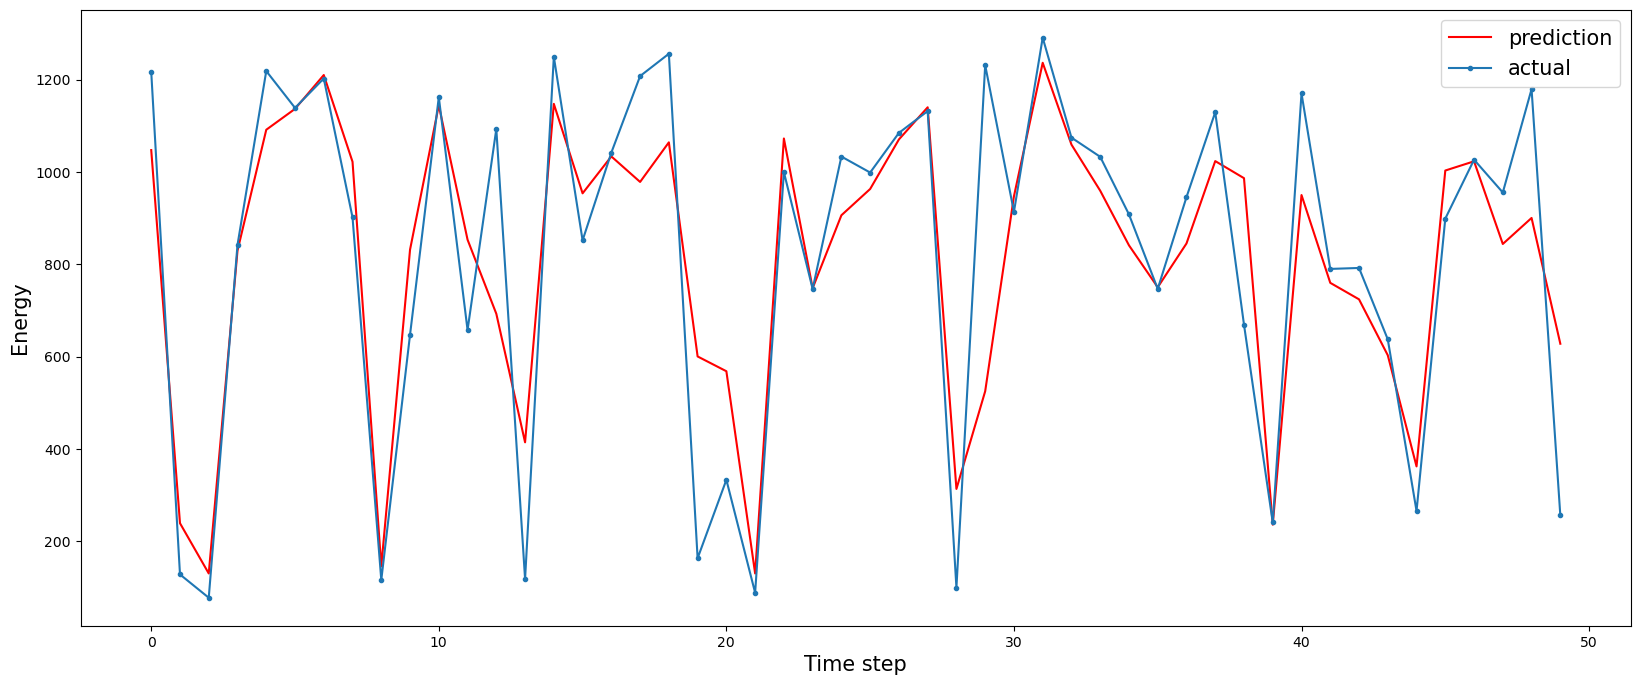

In [13]:
plt.figure(figsize=(20,8))
plt.plot(predictions[:50], label='prediction', color="r")
plt.plot(original[:50], label='actual', marker='.')
plt.legend()
plt.ylabel('Energy', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

plt.show()

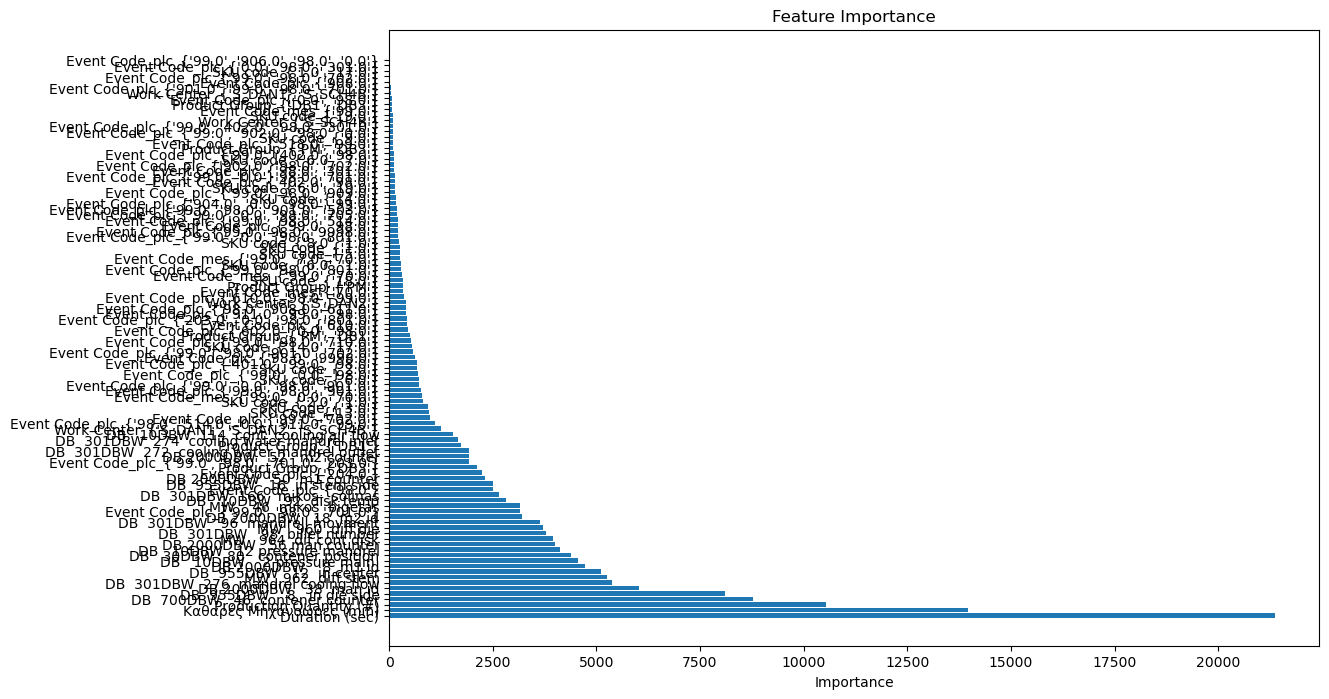

In [8]:
# Assuming 'model' is your trained XGBoost model
# Get feature importances
importance = final_model.get_score(importance_type='weight')

# Convert the importance dictionary to a DataFrame for easier plotting
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

<Figure size 1200x800 with 0 Axes>

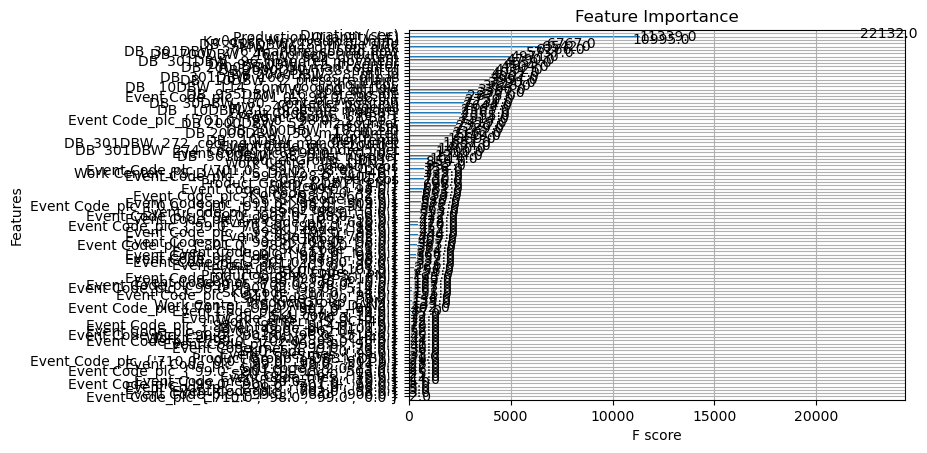

In [7]:
# Plot feature importance
from xgboost import plot_importance

plt.figure(figsize=(12, 8))
plot_importance(model, importance_type='weight')  # You can also use 'gain' or 'cover'
plt.title('Feature Importance')
plt.show()


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


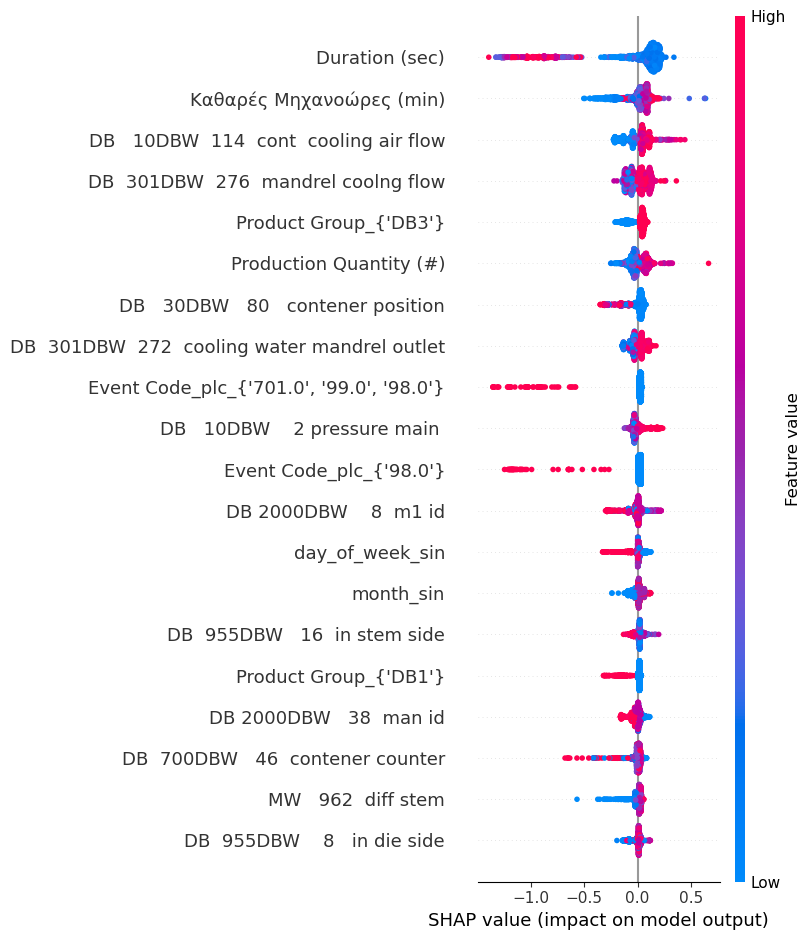

In [8]:
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_combined)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_combined)